## Twitter Sentiment Analysis

>Problem Statement

- The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

- Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

In [1]:
# necessary imports

import numpy as np
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot
# import seaborn as sns
import re

In [2]:
train_data = read_csv('train_.csv')
test_data = read_csv('test_.csv')

In [3]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
# printing the shapes of the train and test data

print("Train data shape {} rows and {} columns".format(train_data.shape[0],train_data.shape[1]))
print("Test data shape {} rows and {} columns".format(test_data.shape[0],test_data.shape[1]))

Train data shape 31962 rows and 3 columns
Test data shape 17197 rows and 2 columns


### Data Preparation

In [5]:
# checking the na in data

train_data.isna().sum()

id       0
label    0
tweet    0
dtype: int64

### EDA

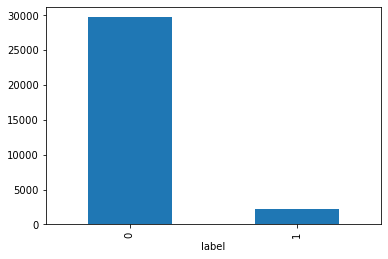

In [6]:
# lest the whether the dataset is imbalance or not 
train_data.groupby(by='label')['label'].count().plot(kind='bar')
pyplot.show()

label_values = train_data.label.value_counts().values
label_classes = train_data.label.value_counts().index
total = label_values.sum()

In [7]:
for i in range(len(label_values)):
    print("For class \"{}\" count = {}, percentage = {} %".format(label_classes[i],label_values[i],round((label_values[i]/total)*100),2))

For class "0" count = 29720, percentage = 93 %
For class "1" count = 2242, percentage = 7 %


##### as we can see the data is pretty imbalaced with 93:7 ratio

### Data Cleaning and Preparation 

>Initial data cleaning requirements that we can think of after looking at the top 5 records:
> - The Twitter handles are already masked as @user due to privacy concerns. So, these Twitter handles are hardly giving any information about the nature of the tweet.
> - We can also think of getting rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different kinds of tweets.
> - Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.
> - Once we have executed the above three steps, we can split every tweet into individual words or tokens which is an essential step in any NLP task.
> - In the 4th tweet, there is a word ‘love’. We might also have terms like loves, loving, lovable, etc. in the rest of the data. These terms are often used in the same context. If we can reduce them to their root word, which is ‘love’, then we can reduce the total number of unique words in our data without losing a significant amount of information.


In [8]:
# checking sample tweets
train_data.tweet[:5]

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

> As we can see the tweets contain lots of twitter handles (@user), that is how a Twitter user acknowledged on Twitter. We will remove all these twitter handles from the data as they don’t convey much information.
> For our convenience, let’s first combine train and test set. This saves the trouble of performing the same steps twice on test and train.

##### adding both the train and test data so that we don't need to prepare the test data again


In [9]:
data_combi = train_data.append(test_data,ignore_index = True)

In [10]:
data_combi.shape

(49159, 3)

#### Removing the Twitter Handles

In [11]:
def remove_pattern(input_txt,pattern):
    
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i," ",input_txt)
    return input_txt

In [12]:
# testing out function
remove_pattern(train_data.tweet[0],'@[\W]*')

'  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [13]:
data_combi['clean_tweet'] = np.vectorize(remove_pattern)(data_combi['tweet'],'@[\w]*')

#### removing Punctuations, Numbers and Special Characters

In [14]:
data_combi['clean_tweet'] = data_combi.clean_tweet.str.replace('[^a-zA-Z#]'," ")

<ipython-input-14-f4dba00dea53>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_combi['clean_tweet'] = data_combi.clean_tweet.str.replace('[^a-zA-Z#]'," ")


#### Removing Short Words

In [15]:
data_combi['clean_tweet'] = data_combi.clean_tweet.apply(lambda x : ' '.join([w for w in x.split() if len(w) > 3]))

In [16]:
# have a look on few top records
data_combi.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


#### Tokenization

    
    -Tokenization is a process of splitting a string of text into tokens

In [17]:
tokenized_tweets = data_combi.clean_tweet.str.split()

In [18]:
tokenized_tweets.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

#### Stemming 

> to strip the suffixes and will get the root word for a paricular word

In [19]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

In [20]:
tokenized_tweets = tokenized_tweets.apply(lambda x : [stemmer.stem(i) for i in x]) # stemming

In [21]:
tokenized_tweets.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

##### now lets add these tokens back together to form a sentence 

In [22]:
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = " ".join(tokenized_tweets[i])

data_combi['clean_tweet'] = tokenized_tweets

In [23]:
data_combi['clean_tweet'].head()

0    when father dysfunct selfish drag kid into dys...
1    thank #lyft credit caus they offer wheelchair ...
2                                  bihday your majesti
3                           #model love take with time
4                             factsguid societi #motiv
Name: clean_tweet, dtype: object

### Story Generation and Visualization from Tweets

#### Understanding the common words used in the tweets :Using WordCloud

In [26]:
from wordcloud import WordCloud

In [27]:
# lets store all the text in a variable

all_text = ' '.join([tweet for tweet in data_combi['clean_tweet']])

In [28]:
wordcloud = WordCloud(width=800,height=500,random_state = 42,max_font_size=110).generate(all_text)

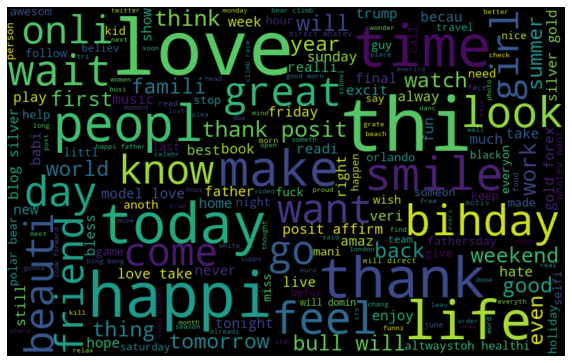

In [29]:
pyplot.figure(figsize=(10,7))
pyplot.imshow(wordcloud,interpolation='bilinear')
pyplot.axis('off')
pyplot.show()

#### Words in non sexist/racist tweets 

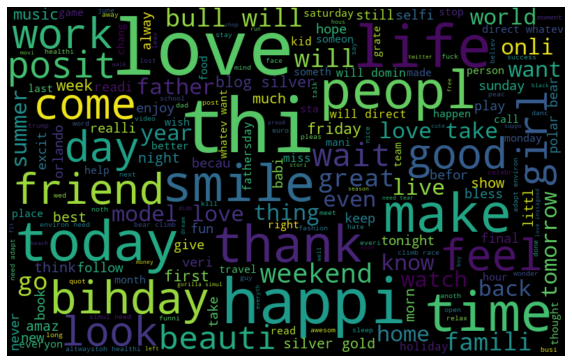

In [30]:
normal_words = ''.join([tweet for tweet in data_combi['clean_tweet'][data_combi['label'] == 0]])

wordcloud = WordCloud(width=800,height=500,random_state = 42,max_font_size=110).generate(normal_words)

pyplot.figure(figsize=(10,7))
pyplot.imshow(wordcloud,interpolation='bilinear')
pyplot.axis('off')
pyplot.show()

#### Words in Sexist/Racists Tweets

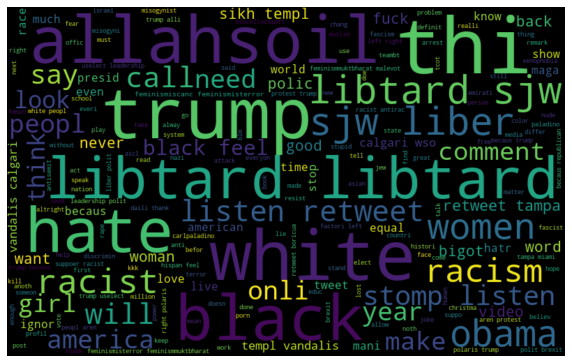

In [31]:
negative_words = ''.join([tweet for tweet in data_combi['clean_tweet'][data_combi['label'] == 1]])

wordcloud = WordCloud(width=800,height=500,random_state = 42,max_font_size=110).generate(negative_words)

pyplot.figure(figsize=(10,7))
pyplot.imshow(wordcloud,interpolation='bilinear')
pyplot.axis('off')
pyplot.show()

#### Understanding the impact of hashtags on tweets sentiment

 
    -lets collect the hashtags in two lists - one for non racist/sexist tweets and other for racist/sexist tweets

In [32]:
def collect_hashtags(tweet):
    hashtags = []
    
    # loop over the words in the tweet
    for word in tweet:
#         print(word)
        ht = re.findall(r'#[\w]+',word)
        hashtags.append(ht)
    return hashtags

In [33]:
# extracting the hashtags for the non racist/sexist tweets 

ht_regular = collect_hashtags(data_combi['clean_tweet'][data_combi['label']==0])

# extracting the hashtags for the racist/sexist tweets 

ht_negative = collect_hashtags(data_combi['clean_tweet'][data_combi['label']==1])

#unnesting list
ht_regular = sum(ht_regular,[])
ht_negative = sum(ht_negative,[])

##### Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

#### Non-racist/sexist Tweets

In [34]:
from nltk import FreqDist

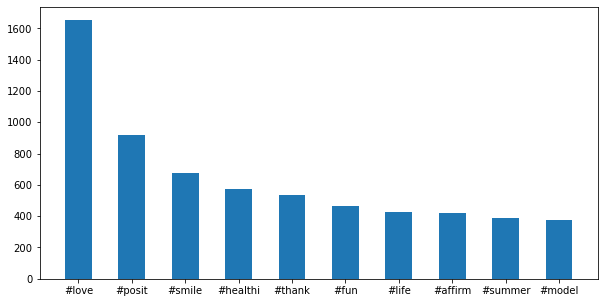

In [35]:
freq_words = FreqDist(ht_regular)
d = DataFrame({'Hashtag':list(freq_words.keys()),
               'Count': list(freq_words.values())})

# selecting the top 10 features
d_top10 = d.nlargest(columns='Count',n = 10)

pyplot.figure(figsize=(10,5))
pyplot.bar(d_top10.Hashtag.values,d_top10.Count.values,width=0.5)
pyplot.ylabel='Count'
pyplot.xlabel= 'Hashtag'
pyplot.show()

#### racist/sexist Tweets

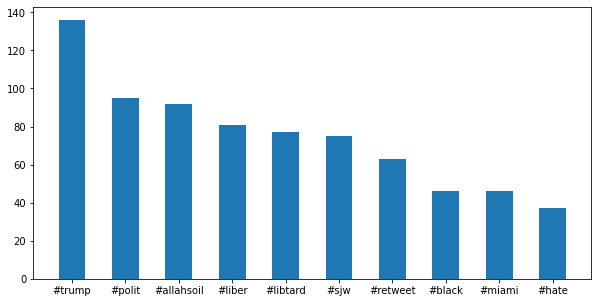

In [36]:
freq_words = FreqDist(ht_negative)
d = DataFrame({'Hashtag':list(freq_words.keys()),
               'Count': list(freq_words.values())})

# selecting the top 10 features
d_top10 = d.nlargest(columns='Count',n = 10)

pyplot.figure(figsize=(10,5))
pyplot.bar(d_top10.Hashtag.values,d_top10.Count.values,width=0.5)
pyplot.ylabel='Count'
pyplot.xlabel= 'Hashtag'
pyplot.show()

### Extracting Features from the Cleaned Tweets

#### Using Bag-of-Words / CountVectorizer 

     Bag-of-Words is a method to represent text into numerical features. Consider a corpus (a collection of texts) called C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a list, and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).
     
Let us understand this using a simple example. Suppose we have only 2 document

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The list created would consist of all the unique tokens in the corpus C.

= [‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –
<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2018/07/table.png'>


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df = 0.90,min_df=2,max_features = 1000,stop_words="english")

# bag of words feature matrix
bow = bow_vectorizer.fit_transform(data_combi['clean_tweet'])

#### TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

- TF = (Number of times term t appears in a document)/(Number of terms in the document)
- IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
- TF-IDF = TF*IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df=2,max_features = 1000,stop_words='english')

# TF-IDF features matrix

tfidf_features = tfidf_vectorizer.fit_transform(data_combi['clean_tweet'])

### Model Building

    We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF. We will use the following algorithms to build models:
    
    - Logistic Regression
    - Support Vector Machine
    - Random Forest

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [55]:
train_bow = bow[:31962]
test_bow = bow[31962:]

# splitting the train data into train and validation set
X_train_bow,X_val_bow,y_train,y_val = train_test_split(train_bow,train_data['label'],random_state = 42,test_size = 0.3)

# creating the model

lreg = LogisticRegression()
lreg.fit(X_train_bow,y_train) # training the model

prediction = lreg.predict_proba(X_val_bow) # predicting on the validation set

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

<ipython-input-55-60a3394cf2ad>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


In [42]:
# score

f1_score(y_val,prediction_int)

0.5303408146300915

In [43]:
# we have tried on the validation data, test try on the test data

test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

<ipython-input-43-b54c2257b41c>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_pred_int = test_pred_int.astype(np.int)


In [44]:
test_data['label'] = test_pred_int

In [45]:
submission = test_data[['id','label']]
submission.to_csv('sub_lreg_bow.csv',index=False)

##### Lets again train the logistic Regression, now this time using the tf-idf features

In [54]:
train_tfidf = tfidf_features[:31962]
test_tfidf = tfidf_features[31962:]

# splitting the train data into train and validation set
X_train_tfidf,X_val_tfidf,y_train,y_val = train_test_split(train_tfidf,train_data['label'],random_state = 42,test_size = 0.3)

# creating the model

lreg = LogisticRegression()
lreg.fit(X_train_tfidf,y_train) # training the model

prediction = lreg.predict_proba(X_val_tfidf) # predicting on the validation set

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)


<ipython-input-54-3fd0dc8adfce>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


In [47]:
f1_score(y_val,prediction_int)

0.5451327433628319

In [51]:
# we have tried on the validation data, test try on the test data

test_pred = lreg.predict_proba(test_tfidf)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

test_data['label1'] = test_pred_int

submission = test_data[['id','label1']]
submission.to_csv('sub_lreg_tfidf.csv',index=False)

<ipython-input-51-cf229565e340>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_pred_int = test_pred_int.astype(np.int)


> Support Vector Machine 

In [53]:
from sklearn.svm import SVC

In [63]:

svc = SVC(kernel='linear',C=5,probability=True).fit(X_train_bow,y_train) # training the model

prediction = svc.predict_proba(X_val_bow) # predicting on the validation set

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(y_val,prediction_int)

<ipython-input-63-1322b8f2c6d6>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


0.5102803738317757

In [64]:
# on tfid features

svc = SVC(kernel='linear',C=5,probability=True).fit(X_train_bow,y_train) # training the model

prediction = svc.predict_proba(X_val_tfidf) # predicting on the validation set

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(y_val,prediction_int)

<ipython-input-64-be97de215e4e>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


0.41098901098901097

> Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [68]:

rfc = RandomForestClassifier(n_estimators = 400,random_state = 10)
rfc.fit(X_train_bow,y_train) # training the model

prediction = rfc.predict(X_val_bow) # predicting on the validation set

f1_score(y_val,prediction)

0.5458860759493672

In [69]:

rfc = RandomForestClassifier(n_estimators = 400,random_state = 10)
rfc.fit(X_train_tfidf,y_train) # training the model

prediction = rfc.predict(X_val_tfidf) # predicting on the validation set

f1_score(y_val,prediction)

0.561694290976059

 > XGBoost

In [70]:
from xgboost import XGBClassifier

In [72]:
xgb = XGBClassifier(n_estimators = 1000,max_depth = 6)
xgb.fit(X_train_bow,y_train) # training the model

prediction = rfc.predict(X_val_bow) # predicting on the validation set

f1_score(y_val,prediction)

C:\Users\vamsi katam\.conda\envs\nlp\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:39:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.42036836403033584

In [73]:
xgb = XGBClassifier(n_estimators = 1000,max_depth = 6)
xgb.fit(X_train_tfidf,y_train) # training the model

prediction = rfc.predict(X_val_tfidf) # predicting on the validation set

f1_score(y_val,prediction)

C:\Users\vamsi katam\.conda\envs\nlp\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:40:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.561694290976059